# Experiments on the generalization error of distributed SVM 
### May 2022

These experiments correpond to the section A of the supplementary materials in the paper "Rate-Distortion Theoretic Bounds on
Generalization Error for Distributed Learning" submitted to NeurIPS 2022 conference.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *


plt.rcParams.update({'font.size': 14})
warnings.filterwarnings("ignore")

In [3]:
"""
Parameters/Hyperparameters that the user can set. 
Values in the dictionnary 'params' can be changed but the user is not encouraged to do so as these
parameters are optimized to obtain the results presented in the paper.
"""
SEED = 193 # Seed for reproducibility
PATH = "" # Path to folder containing MNIST data

class1 = 1 # Label of class 1
class2 = 6 # Label of class 2

M = 1 # Number of simulations (for more stable results)
n = 300 # Size of each client dataset
num_values = 5 # Number of different values of K to use

params = {
    "alpha":0.00001, # L2 regularization hyperparameter
    "lr":0.01, # Learning rate
    "client_epochs":200, # Client model number of epochs
    "epochs":200, # Centralized model number of epochs
    "n_rounds":1, # Number of distributed rounds
    "gamma":0.01, # Kernel hyperparameter
    "proj_dim":2000, # Dimension of the kernel feature space
    "theta":0, # Margin size parameter
    "min_risk":0.001 # Minimum empirical risk to reach to stop training
}

In [4]:
###########################################
# PLEASE DO NOT CHANGE ANYTHING IN THIS CELL
data = load_binary_data(class1, class2, path=PATH, proj_dim=params["proj_dim"], gamma=params["gamma"])
K_values = np.linspace(2, data["X"].shape[0]//n, num_values, dtype=int) 

df = pd.DataFrame(0, 
                  index=K_values, 
                  columns=["dis_emp_risks", "dis_risks", "emp_risks", "risks", "bias", "dis_times", "times"])
for r in range(M):
    dis_emp_risks, dis_risks = [], []
    emp_risks, risks = [], []
    dis_times, times = [], []
    bias = []
    for K in K_values:
        N = n*K
        print("K = {}, N = {}".format(K, N))
        
        idxs = np.random.permutation(data["X"].shape[0])[:N]
        
        start = time.time()
        server = distributed_learning(data, idxs, params, K, seed=SEED)
        end = time.time()
        dis_times.append(end-start)
        print("Distributed learning setup total runtime: {0:.3f}s.".format(end-start))
        
        dis_emp_risks.append(server.emp_risks[-1])
        dis_risks.append(server.test_risks[-1])
        bias.append(server.emp_risks[-1] - np.mean(server.local_emp_risks))
        print("==============================")
        
        start = time.time()
        emp_risk, risk = centralized_learning(data, idxs, params, seed=SEED)
        end = time.time()
        times.append(end-start)
        print("Centralized learning setup total runtime: {0:.3f}s.".format(end-start))
        
        emp_risks.append(emp_risk)
        risks.append(risk)
        print("===============================================")
    df["dis_emp_risks"] += dis_emp_risks
    df["dis_risks"] += dis_risks
    df["emp_risks"] += emp_risks
    df["risks"] += risks
    df["bias"] += bias
    df["dis_times"] += dis_times
    df["times"] += times
    
df /= M
df["dis_gen"] = df["dis_risks"] - df["dis_emp_risks"]
df["gen"] = df["risks"] - df["emp_risks"]
# PLEASE DO NOT CHANGE ANYTHING IN THIS CELL
###########################################

K = 2, N = 600


  0%|          | 0/2 [00:00<?, ?it/s]

Distributed learning setup total runtime: 1.100s.


  0%|          | 0/199 [00:00<?, ?it/s]

Centralized learning setup total runtime: 4.614s.
K = 12, N = 3600


  0%|          | 0/12 [00:00<?, ?it/s]

Distributed learning setup total runtime: 4.873s.


  0%|          | 0/199 [00:00<?, ?it/s]

Centralized learning setup total runtime: 41.979s.
K = 22, N = 6600


  0%|          | 0/22 [00:00<?, ?it/s]

Distributed learning setup total runtime: 9.542s.


  0%|          | 0/199 [00:00<?, ?it/s]

Centralized learning setup total runtime: 71.161s.
K = 32, N = 9600


  0%|          | 0/32 [00:00<?, ?it/s]

Distributed learning setup total runtime: 12.369s.


  0%|          | 0/199 [00:00<?, ?it/s]

Centralized learning setup total runtime: 109.008s.
K = 42, N = 12600


  0%|          | 0/42 [00:00<?, ?it/s]

Distributed learning setup total runtime: 18.928s.


  0%|          | 0/199 [00:00<?, ?it/s]

Centralized learning setup total runtime: 138.457s.


In [5]:
df["dis_bounds"] = [compute_bound(n, K, theta=params["theta"]) for K in K_values]
df["bounds"] = [compute_bound(n*K, 1, theta=params["theta"]) for K in K_values]

In [6]:
df

,dis_emp_risks,dis_risks,emp_risks,risks,bias,dis_times,times,dis_gen,gen,dis_bounds,bounds
2,0.018333,0.134257,0.000000,0.122312,0.018333,1.099503,4.614040,0.115924,0.122312,5.906402,8.121475
12,0.093889,0.127568,0.005833,0.087434,0.093889,4.873045,41.979485,0.033679,0.081601,1.248896,3.745882
22,0.095000,0.118968,0.013182,0.083134,0.095000,9.541715,71.160782,0.023968,0.069952,0.798240,2.866447
32,0.110729,0.131390,0.020938,0.081701,0.110729,12.368856,109.007808,0.020661,0.060763,0.624220,2.426588
42,0.108254,0.125179,0.023175,0.078356,0.108254,18.927839,138.456712,0.016925,0.055182,0.525711,2.149148


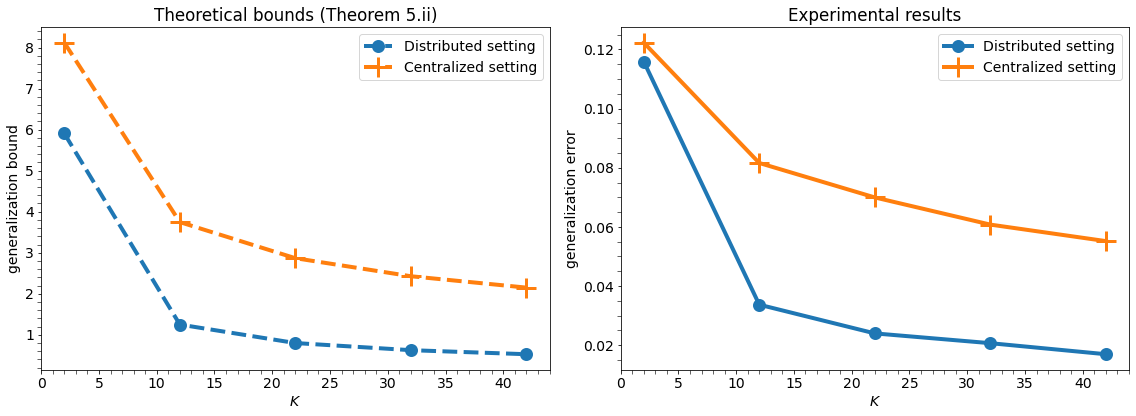

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(K_values, df["dis_bounds"], 
           marker="o", ms=10, mew=3, ls='--', lw=4, 
           label="Distributed setting")
ax[0].plot(K_values, df["bounds"], 
           marker="+", ms=20, mew=3, ls='--', lw=4,
           label="Centralized setting")
ax[0].set(xlabel=r"$K$", ylabel="generalization bound", title="Theoretical bounds (Theorem 5.ii)")
ax[0].minorticks_on()
ax[0].tick_params(which='minor', length=4)
ax[0].legend()

ax[1].plot(K_values, df["dis_gen"], marker="o", ms=10, mew=3, lw=4, label="Distributed setting")
ax[1].plot(K_values, df["gen"], marker="+", ms=20, mew=3, lw=4, label="Centralized setting")
ax[1].set(xlabel=r"$K$", ylabel="generalization error", title="Experimental results")
ax[1].minorticks_on()
ax[1].tick_params(which='minor', length=4)
ax[1].legend()

fig.tight_layout();

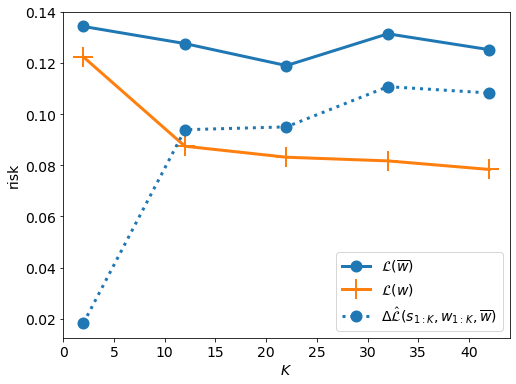

In [8]:
fig2, ax = plt.subplots(figsize=(8, 6))
ax.plot(K_values, df["dis_risks"],            
        marker="o", ms=10, mew=2, lw=3, 
        label=r"$\mathcal{L}(\overline{w})$")
ax.plot(K_values, df["risks"], 
        marker="+", ms=20, mew=2, lw=3,
        label=r"$\mathcal{L}(w)$")
ax.plot(K_values, df["bias"], 
        marker="o", ms=10, mew=2, ls=':', lw=3, c='tab:blue',
        label=r"$\Delta \mathcal{\hat L}(s_{1:K}, w_{1:K}, \overline{w})$")
ax.set(xlabel=r"$K$", ylabel="risk")
ax.legend();

In [9]:
"""
User can uncomment this to save plots in .png files.
"""
# fig.savefig("plot1.png")
# fig2.savefig("plot2.png")

'\nUser can uncomment this to save plots in .png files.\n'